In [31]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from icecream import ic
from torch.utils.data import DataLoader, Dataset
from torchvision.io import ImageReadMode, read_image

In [32]:
root_path = os.path.dirname(os.getcwd())
img_path = f"{root_path}/images"

In [33]:
CLASSES = (
    "empty",
    "black",
    "white",
)

TRAIN_PERCENTAGE = 0.7
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 2


In [34]:
label_tuples = []
for label in CLASSES:
    dir_path = f"{img_path}/{label}"
    dir_files = [
        f"{dir_path}/{f}" for f in os.listdir(f"{dir_path}") if f.endswith(".png")
    ]
    class_labels = [(file_path, CLASSES.index(label)) for file_path in dir_files]
    label_tuples += class_labels

label_tuples[0]

('/Users/roman/git/personal/goban-watcher/images/empty/IMG_1521.jpeg_9_0.png',
 0)

In [35]:
sorted_labels = pd.DataFrame(label_tuples)
sorted_labels[1].value_counts()

1
0    68895
1     1675
2     1630
Name: count, dtype: int64

In [36]:
labels = sorted_labels.sample(frac=1, random_state=42).reset_index(drop=True)
labels[1].value_counts()

1
0    68895
1     1675
2     1630
Name: count, dtype: int64

### Undersample

In [37]:
column_name = sorted_labels.columns[1]

# Count the number of samples in each category
min_count = sorted_labels[column_name].value_counts().min()

# Create a list to hold the undersampled DataFrame
undersampled_df = pd.DataFrame()

# Loop through each category and sample
for label in sorted_labels[column_name].unique():
    undersampled_df = pd.concat(
        [
            undersampled_df,
            sorted_labels[sorted_labels[column_name] == label].sample(
                min_count, random_state=42
            ),
        ]
    )

labels = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
labels[1].value_counts()

1
0    1630
1    1630
2    1630
Name: count, dtype: int64

In [38]:
total_labels = labels.shape[0]
ic(total_labels)
amount_train_labels = int(total_labels * TRAIN_PERCENTAGE)


train_labels, test_labels = (
    labels[:amount_train_labels],
    labels[amount_train_labels:],
)

ic| total_labels: 4890


### Creating a Dataset

In [39]:
class StonesDataset(Dataset):
    def __init__(self, labels: pd.DataFrame, transform=None):
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return self.labels.shape[0]

    def __getitem__(self, idx):
        img_path, label = self.labels.iloc[idx]
        image = read_image(img_path, mode=ImageReadMode.RGB)
        if self.transform:
            image = self.transform(image)
        label = int(label)

        return image, label


transform = transforms.Compose(
    [
        transforms.ToPILImage(),  # ! has to be here otherwise you won't be able to display them later
        transforms.Resize((105, 105)),  # Resize to 105x105
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
    ]
)
train_dataset = StonesDataset(train_labels, transform)
test_dataset = StonesDataset(test_labels, transform)


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)

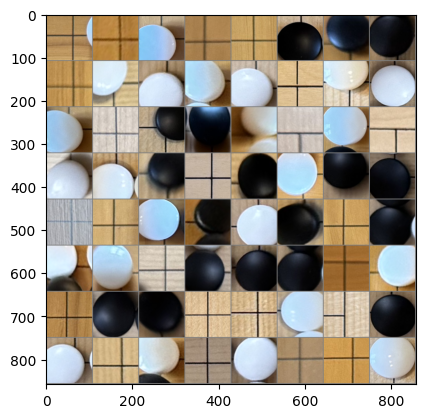

0 0 2 0 0 1 1 1 0 2 2 2 2 0 2 2 2 0 1 1 2 0 2 0 2 2 1 0 1 2 1 1 0 0 2 1 2 1 0 1 2 2 0 1 1 1 0 2 0 1 1 0 0 2 0 1 2 0 2 0 2 0 0 2


In [40]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, label_tuples = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{label_tuples[j]}" for j in range(BATCH_SIZE)))

### Neural Network

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 26 * 26, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()

### Optimizer

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [43]:
total_batches = len(train_labels) // BATCH_SIZE
mini_batches = total_batches // 10
total_batches, mini_batches

(53, 5)

In [46]:
for epoch in range(EPOCHS):
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, label_tuples = data

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, label_tuples)
        running_loss += loss
        loss.backward()
        optimizer.step()

        # running_loss += loss.item()
        if i % mini_batches == 0:
            print(
                f"EPOCH: {epoch + 1}, PERCENTAGE: {i/total_batches:.2f} RUNNING LOSS: {running_loss:.4f}"
            )
            running_loss = 0
print("Finished Training")

EPOCH: 1, PERCENTAGE: 0.00 RUNNING LOSS: 0.0110
EPOCH: 1, PERCENTAGE: 0.09 RUNNING LOSS: 0.1382
EPOCH: 1, PERCENTAGE: 0.19 RUNNING LOSS: 0.1199
EPOCH: 1, PERCENTAGE: 0.28 RUNNING LOSS: 0.0584
EPOCH: 1, PERCENTAGE: 0.38 RUNNING LOSS: 0.0243
EPOCH: 1, PERCENTAGE: 0.47 RUNNING LOSS: 0.0179
EPOCH: 1, PERCENTAGE: 0.57 RUNNING LOSS: 0.0038
EPOCH: 1, PERCENTAGE: 0.66 RUNNING LOSS: 0.0213
EPOCH: 1, PERCENTAGE: 0.75 RUNNING LOSS: 0.0174
EPOCH: 1, PERCENTAGE: 0.85 RUNNING LOSS: 0.0040
EPOCH: 1, PERCENTAGE: 0.94 RUNNING LOSS: 0.0054
EPOCH: 2, PERCENTAGE: 0.00 RUNNING LOSS: 0.0008
EPOCH: 2, PERCENTAGE: 0.09 RUNNING LOSS: 0.0050
EPOCH: 2, PERCENTAGE: 0.19 RUNNING LOSS: 0.0070
EPOCH: 2, PERCENTAGE: 0.28 RUNNING LOSS: 0.0010
EPOCH: 2, PERCENTAGE: 0.38 RUNNING LOSS: 0.0054
EPOCH: 2, PERCENTAGE: 0.47 RUNNING LOSS: 0.0028
EPOCH: 2, PERCENTAGE: 0.57 RUNNING LOSS: 0.0054
EPOCH: 2, PERCENTAGE: 0.66 RUNNING LOSS: 0.0025
EPOCH: 2, PERCENTAGE: 0.75 RUNNING LOSS: 0.0010
EPOCH: 2, PERCENTAGE: 0.85 RUNNING LOSS:

### Save NN

In [52]:
PATH = "stone_classification_weights.pth"
torch.save(net.state_dict(), PATH)

In [53]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0


with torch.no_grad():
    for data in test_loader:
        images, label_tuples = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label_tuples.size(0)
        correct += (predicted == label_tuples).sum().item()
print(
    f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f} %"
)


ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105, 105])
ic| images.shape: torch.Size([64, 3, 105

Accuracy of the network on the 1408 test images: 99.86 %


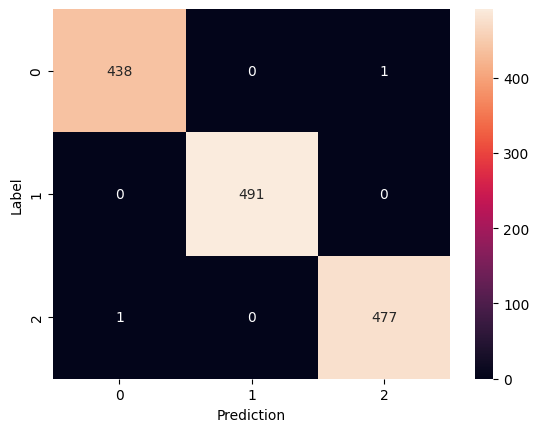

In [57]:
results = []
wrong_images = []

with torch.no_grad():
    for data in test_loader:
        images, label_tuples = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction, image in zip(label_tuples, predictions, images):
            results += [(int(label), int(prediction))]
            if prediction != label:
                wrong_images.append(image)

df = pd.DataFrame(results, columns=["Label", "Prediction"])

heatmap_data = df.pivot_table(
    index="Label", columns="Prediction", aggfunc="size", fill_value=0
)
sns.heatmap(heatmap_data, annot=True, fmt="d")
plt.show()

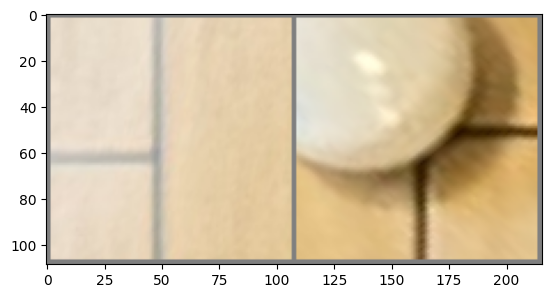

In [58]:
imshow(torchvision.utils.make_grid(wrong_images))